# **This notebook is for the IBM Data Science Capstone Project on Coursera**

by: Alex Henner

## Introduction

There are many people who enjoy traveling to new states, but have a certain palate and would like the ability to pair their tastes with the best cities to travel to in order to get the best experience. In this paper we will explore using a recommendation system to find the top 5 state capitals to visit based on your palate. We will be gathering venue data using Foursquare and will be using the amount of venues in each category based off individual Capitals. We will be focusing our data on the State Capitals.

## Data

We will be using Foursquare API to find food venues around the Capitals of each State. We will then narrow down the food categories into a smaller subset, that will make it easier for the user to rate different types of foods.

Below is the extraction and cleaning of the data.

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

#!pip install geopy
from geopy.geocoders import Nominatim

import time

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

#!pip install folium
import folium

import requests
from pandas.io.json import json_normalize

from secrets import *

Grabbing the State Capitals as well as the Area

In [14]:
#get a table with the State Capitals
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_capitals_in_the_United_States', header=1)
state_cap = wiki[1]
state_cap.drop(index=50, axis=0, inplace=True)
state_cap.drop(['Since', 'Proper', 'MSA/µSA', 'Rank in State (city proper)', 'CSA'], axis=1, inplace=True)

#finding the center latitude/longitude for each State Capital
geolocator = Nominatim(user_agent="ny_explorer")
latitudes = []
longitudes = []

for state, capital in zip(state_cap['State'], state_cap['Capital']):
    location = geolocator.geocode(f'{capital}, {state}')
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

#adding the latitude and longitude for each Capital
state_cap['Latitude'] = latitudes
state_cap['Longitude'] = longitudes 

state_cap.head()

,State,Capital,Area (mi2),Latitude,Longitude
0,Alabama,Montgomery,159.8,32.366966,-86.300648
1,Alaska,Juneau,2716.7,58.301950,-134.419734
2,Arizona,Phoenix,517.6,33.448437,-112.074142
3,Arkansas,Little Rock,116.2,34.746481,-92.289595
4,California,Sacramento,97.9,38.581061,-121.493895


### Visualize the State Capitals

In [32]:
#getting location for center of USA
location = geolocator.geocode('United States')
latitude = location.latitude
longitude = location.longitude - 6  #to get Hawaii in the frame

In [33]:
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4)

#printing State Capitals to map
for lat, lng, capital, state in zip(state_cap['Latitude'], state_cap['Longitude'], state_cap['Capital'], state_cap['State']):
    label = f'{capital}, {state}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa) 

map_usa

Getting venues based off the 27 categories I narrowed it down to

In [7]:
def getNearbyVenues(capital, state, latitudes, longitudes, radius=100000):
    
    venues_list=[]
    search_querys = ['African Restaurant',
 'American Restaurant',
 'Asian Restaurant',
 'Bar',
 'Breakfast',
 'Buffet',
 'Chinese Restaurant',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Dessert Shop',
 'Eastern European Restaurant',
 'Fast Food Restaurant',
 'Food Truck',
 'French Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Latin American Restaurant',
 'Mediterranean Restaurant',
 'Middle Eastern Restaurant',
 'Modern European Restaurant',
 'Sandwich Place',
 'Seafood Restaurant',
 'Southern / Soul Food Restaurant',
 'Spanish Restaurant',
 'Vegetarian / Vegan Restaurant']
    
    
    for capital, state, lat, lng, rad in zip(capital, state, latitudes, longitudes, radius):
        #print(f'Getting locations from {capital}, {state}')
        time.sleep(1)
        count = 0
        for search_query in search_querys:
            
            # finding radius using sq mi area of Capital or the max limit for Foursquare, whichever is lower
            radius = min(int(((float(rad)**0.5) / 2) * 1609.34), 100000)  #Assuming sq mi is actual square centered at location and change to meters

            # format url
            time.sleep(0.1)
            url = url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lng}&v={VERSION}&query={search_query}&radius={radius}&limit={LIMIT}'
            
            # make the GET request
            try:
                results = requests.get(url).json()["response"]['venues']
            except:
                results = requests.get(url).json()
                print(results['meta'])
                continue
            
            # return only relevant information for each nearby venue
            for v in results:
                try:
                    venues_list.append([ capital,
                        state,
                        lat, 
                        lng, 
                        v['id'],
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],  
                        v['categories'][0]['name']])
                except:
                    venues_list.append([ capital,
                        state,
                        lat, 
                        lng, 
                        v['id'],
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],  
                        np.nan])
                finally:
                    count += 1
        #print(f'Found {count} venues\n\n')
                    
    nearby_venues = pd.DataFrame(venues_list)
    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital',
                  'State',
                  'Capital Latitude', 
                  'Capital Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
capital_venues = getNearbyVenues(state_cap['Capital'], state_cap['State'], state_cap['Latitude'], state_cap['Longitude'], state_cap['Area (mi2)'])
capital_venues.head()

{'code': 200, 'requestId': '600af6490d13d94ee1c188a6'}


,Capital,State,Capital Latitude,Capital Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Montgomery,Alabama,32.366966,-86.300648,4ddcb5c6887775ea9c471929,African Hair Braiding,32.329065,-86.284113,Salon / Barbershop
1,Montgomery,Alabama,32.366966,-86.300648,4ba0e0dcf964a520108437e3,National Center For The Study Of Civil Rights ...,32.360270,-86.289501,General College & University
2,Montgomery,Alabama,32.366966,-86.300648,4d80140b208a54815ca56e67,Odessa's Blessings,32.371350,-86.286923,Southern / Soul Food Restaurant
3,Montgomery,Alabama,32.366966,-86.300648,4f32730a19836c91c7d8ed44,Genesis Restaurant,32.366365,-86.312476,Food
4,Montgomery,Alabama,32.366966,-86.300648,4e3437f21838df3b5f772334,Choices,32.378931,-86.310192,Chinese Restaurant


In [9]:
x1 = capital_venues.shape[0]
#drop any venue duplicates picked up by the different search queries
capital_venues.drop_duplicates(subset=['ID'], inplace=True)
x2 = capital_venues.shape[0]
print(f'Started off with {x1} venues, deleted {x1 - x2} duplicates, leaving {x2} venues')

Started off with 34502 venues, deleted 19479 duplicates, leaving 15023 venues


In [10]:
#saving
capital_venues.to_csv('capital_venues.csv')

In [16]:
#opening so to not have to rerun
capital_venues = pd.read_csv('capital_venues.csv')
capital_venues.drop('Unnamed: 0',1, inplace=True)

#### **Cleaning the data grabed from Foursquare. Deleted non food venues and changed the category name of some venues to fit them into the 27 categories. Assumptions are below.**

In [17]:
#list of venues not related to food
drop_venues = ['Tanning Salon','TV Station','Eye Doctor','Newsstand','Festival','Ski Lodge', 'Shoe Repair', 'Golf Course',
                'Castle', 'Hockey Field', 'Palace', 'Dive Shop', 'Truck Stop','Record Shop','Photography Lab','Industrial Estate', 'College Stadium',
                'Platform', 'City Hall', 'Adult Boutique','Cycle Studio', 'Bowling Alley','Skate Shop', 'Camera Store', 'Voting Booth',
                'Supplement Shop','Costume Shop', 'Bike Rental / Bike Share','Hunting Supply', 'Fountain', 'Frame Store', 'Baseball Stadium',
                'Fishing Spot', 'Laundromat', 'Used Auto Dealership','Maternity Clinic', 'Drive-in Theater', 'Knitting Store',
                'Law School',  'Pop-Up Shop','State / Provincial Park','Beer Store', 'Tram Station', 'Art Studio', 'Recruiting Agency', 'Indoor Play Area','Light Rail Station', 'Music Store', 'Indie Movie Theater',
                'Souvenir Shop', 'Fire Station', 'Motorcycle Shop','Trailer Park','RV Park', 'Middle School','Soccer Field', 'Astrologer', 'Outdoor Sculpture', 'Preschool',
                'Entertainment Service', 'Synagogue', 'Fabric Shop', 'Tennis Stadium', 'Rock Climbing Spot','Motorsports Shop', 'Betting Shop', 'Fishing Store','Rental Car Location', 'Tourist Information Center', 'Gun Range','Comic Shop', 'Train Station', 'Hotel', 'Motel', 'Event Space', 'Pet Service', 'Comedy Club', 'Concert Hall', 'Farm', 'Church', 'General Travel', 'Train', 'Gourmet Shop', 'Non-Profit', 'Conference Room', 'Building', 'Other Great Outdoors', 'Parking', 'Gift Shop', 'College Quad', 'Auditorium', 'Health & Beauty Service', 'Scenic Lookout', 'Clothing Store', 'Office', 'Toy / Game Store', 'Government Building', 'Tour Provider', 'Grocery Store', 'Food Service', 'Convenience Store', 'Liquor Store', 'Supermarket', 'Gas Station', 'Miscellaneous Shop', 'Massage Studio', 'Business Center', 'Medical Center', 
                'Paper / Office Supplies Store', 'Car Wash', 'Arcade', 'Construction & Landscaping', 'Market', 'Bank', 'Tattoo Parlor', 'Financial or Legal Service', 'Campaign Office', 'General College & University', 'River', 'Trail', 'Monument / Landmark', 'Bike Trail', 'High School', 'Capitol Building', 'College Classroom', 'Sculpture Garden', 'Factory', 'Intersection', 'Club House', "Doctor's Office", 'Cosmetics Shop', 'Art Gallery', 'Community College', 'Insurance Office', 'Furniture / Home Store', 'Thrift / Vintage Store', 'Assisted Living', 'Bridge', 'Outdoor Supply Store', 'Plane', 'Automotive Shop', 'Garden',
                'Boat or Ferry', 'Historic Site', 'Spiritual Center', 'Residential Building (Apartment / Condo)', 'Martial Arts School', 'Shopping Plaza', 'General Entertainment', 'Beach', 'Farmers Market', 'Coworking Space', 'Jewelry Store', 'IT Services', 'Theater', 'Travel Agency', 'Warehouse Store', 'Kitchen Supply Store', 'Bridal Shop', 'Hospital', 'Spa', 'Smoke Shop', 'Hobby Shop', 'Housing Development', 'Gym / Fitness Center', 'Basketball Court', 'Discount Store', 'Sporting Goods Shop', "Men's Store", 'Auto Dealership', 'Business Service', 'Storage Facility', 'Hardware Store', 'Cultural Center', 'Check Cashing Service', 
                'Print Shop', 'Pharmacy', 'Park', 'Cruise Ship', 'Lingerie Store', 'Other Repair Shop', 'Home Service', 'Professional & Other Places', 'Warehouse', 'Coffee Roaster', 'Distribution Center', 'Travel Lounge', 'Performing Arts Venue', 'Pedestrian Plaza', 'Yoga Studio', 'Island', 'Plaza', 'Locksmith', 'College Residence Hall', 'Athletics & Sports', 'Recreation Center', 'Real Estate Office', 'Lounge', 'Airport Gate', 'Lawyer', 'Dance Studio', 'Botanical Garden', 'National Park', 'Resort', 'Lake', 'Convention Center', 'Airport Service', 'Social Club', "Dentist's Office", 'Credit Union', 'Moving Target', 'Trade School',
                'Acupuncturist', 'Candy Store', 'Night Market', 'Department Store', 'Ski Chalet', 'Well', 'Exhibit', 'Arts & Entertainment', 'Music Venue', 'Student Center', 'Outlet Store', 'Gym', 'Nursery School', 'Airport Terminal', 'Research Laboratory', 'Library', 'Airport', 'Electronics Store', 'Road', 'Salon / Barbershop', 'Shoe Store', 'Recycling Facility', 'Chiropractor', 'Tech Startup', 'Marijuana Dispensary', 'Herbs & Spices Store', 'Gaming Cafe', 'School', 'Science Museum', 'Pet Store', 'Mobile Phone Shop', 'Other Nightlife', 'Tailor Shop', 'Advertising Agency',  'College Administrative Building',  'Pool', 'Design Studio',
                'Boutique', 'Laundry Service', 'Transportation Service', 'Art Museum', 'College & University', 'Zoo Exhibit',  'EV Charging Station', 'Shop & Service', 'Field', 'Nightclub', 'Rehab Center', 'Bus Stop', 'Shopping Mall', 'Arts & Crafts Store', 'Physical Therapist', 'Racetrack', 'College Auditorium', 'Antique Shop', 'Community Center', 'Garden Center', "Women's Store", 'Outdoors & Recreation', 'Taxi', 'Auto Workshop', 'Auto Garage', 'College Academic Building', 'Nightlife Spot', 'Bike Shop', 'Tennis Court', 'Meeting Room', 'Shrine', 'Indie Theater', 'Medical Lab', 'College Lab', 'Water Park', 'Bus Line', 'Baseball Field',
                'Fraternity House', 'Daycare', 'Sports Club', 'Museum', 'Embassy / Consulate', 'Sorority House', 'University', 'Animal Shelter', 'Zoo', 'Vehicle Inspection Station', 'Harbor / Marina', 'Line / Queue', 'Other Event', 'Hotel Pool', 'ATM', 'College Theater', 'Carpet Store', 'Airport Lounge', 'Cemetery', 'Language School', 'Outdoor Event Space', 'College Communications Building', 'Fruit & Vegetable Store', 'Flea Market', 'Accessories Store', 'Gun Shop', 'Pier', 'History Museum', 'Fair', 'Post Office', 'Hockey Arena', 'Event Service', 'Medical School', 'Skate Park', 'Playground', 'Bookstore', 'Police Station', 'Military Base',
                'Paintball Field', 'Alternative Healer', 'Vape Store', 'College Science Building', 'Veterinarian', 'Lighting Store', 'Mental Health Office', 'College History Building', "Veterans' Organization", 'Corporate Amenity', 'Tunnel', 'Metro Station', 'Music School', 'Outdoor Gym', 'Big Box Store', 'Hospital Ward', 'Movie Theater', 'Rock Club', 'Organic Grocery', 'Kids Store', 'Dog Run', 'Campground', 'Disc Golf', 'Surf Spot', 'Radio Station', 'Elementary School', 'Neighborhood', 'Circus', 'Outlet Mall', 'Bus Station', 'Child Care Service', 'Flower Shop', 'Rest Area', 'Butcher', 'Hot Spring', 'Dry Cleaner', 'Travel & Transport',
                'College Basketball Court', 'Prison', 'Mattress Store', 'Temple', 'Board Shop', 'College Library', 'Courthouse', 'Video Game Store', 'City', 'Bathing Area', 'College Rec Center', 'College Bookstore', 'Casino', 'Pawn Shop', 'Video Store', 'Baby Store', 'Skating Rink', 'Jazz Club', 'Rental Service', 'Baggage Claim', 'College Gym', 'Vacation Rental', 'Funeral Home', 'Emergency Room', 'Multiplex', 'Theme Park', 'Stadium', 'Stables', 'Boxing Gym', 'Escape Room', 'College Technology Building', 'Public Art', 'Memorial Site', 'Wine Shop', 'Amphitheater', 'Track', 'Nail Salon', 'Hostel', 'College Arts Building', 'Roof Deck', 'Pool Hall',
                'Waterfall', 'Optical Shop', 'Internet Cafe', 'Picnic Area', 'Shipping Store', 'Distillery', 'Fish Market', 'Health Food Store', 'Cheese Shop']

capital_venues.drop(capital_venues[capital_venues['Venue Category'].isin(drop_venues)].index, inplace=True)
capital_venues.dropna(0, inplace=True)


In [18]:
def venue_change(category):
    if category in ['Moroccan Restaurant', 'Ethiopian Restaurant']:
        category = 'African Restaurant'
    elif category in ['Café', 'Snack Place', 'Bakery', 'Tea Room', 'Bubble Tea Shop', 'Corporate Coffee Shop', 'Juice Bar']:
        category = 'Coffee Shop'
    elif category in ['Street Food Gathering']:
        category = 'Food Truck'
    elif category in ['Smoothie Shop','Breakfast Spot', 'Bed & Breakfast', 'Bagel Shop', 'Donut Shop', 'Creperie']:
        category = 'Breakfast'
    elif category in ['Salvadoran Restaurant','Peruvian Restaurant','Churrascaria','South American Restaurant', 'Taco Place', 'Burrito Place', 'Mexican Restaurant', 'Argentinian Restaurant', 'Cuban Restaurant', 'Brazilian Restaurant', 'Portuguese Restaurant', 'Caribbean Restaurant']:
        category = 'Latin American Restaurant'
    elif category in ['Food & Drink Shop', 'Food Court', 'Bistro', 'Food Stand', 'Airport Food Court', 'Food', 'Restaurant']:
        category = 'Fast Food Restaurant'
    elif category in ['Theme Restaurant', 'New American Restaurant', 'Diner', 'Steakhouse', 'Burger Joint', 'Hot Dog Joint', 'Tex-Mex Restaurant', 'Hawaiian Restaurant']:
        category = 'American Restaurant'
    elif category in ['Cafeteria', 'College Cafeteria', 'Corporate Cafeteria',]:
        category = 'Buffet'
    elif category in ['South Indian Restaurant','Indian Chinese Restaurant','Andhra Restaurant', 'North Indian Restaurant', 'Sri Lankan Restaurant']:
        category = 'Indian Restaurant'
    elif category in ['Pizza Place']:
        category = 'Italian Restaurant'
    elif category in ['Beach Bar','Irish Pub', 'Fish & Chips Shop','Wine Bar', 'Brewery', 'Winery', 'Sake Bar', 'Karaoke Bar',  'Strip Club',  'Dive Bar',  'Sports Bar',  'Speakeasy', 'Pub', 'Hookah Bar', 'Gay Bar', 'Cocktail Bar', 'Whisky Bar', 'Hotel Bar', 'Piano Bar', 'Tiki Bar', 'Beer Bar', 'Gastropub', 'Beer Garden']:
        category = 'Bar'
    elif category in ['Deli / Bodega']:
        category = 'Sandwich Place'
    elif category in ['Hunan Restaurant','Dumpling Restaurant', 'Szechuan Restaurant', 'Malay Restaurant', 'Shanghai Restaurant', 'Dim Sum Restaurant']:
        category = 'Chinese Restaurant'
    elif category in ['Indonesian Restaurant','Tibetan Restaurant','Cantonese Restaurant','Mongolian Restaurant', 'Thai Restaurant', 'Filipino Restaurant', 'Vietnamese Restaurant', 'Noodle House']:
        category = 'Asian Restaurant'
    elif category in ['Gluten-free Restaurant','Salad Place']:
        category = 'Vegetarian / Vegan Restaurant'
    elif category in ['Tapas Restaurant']:
        category = 'Spanish Restaurant'
    elif category in ['Greek Restaurant']:
        category = 'Mediterranean Restaurant'
    elif category in ['Korean BBQ Restaurant']:
        category = 'Korean Restaurant'
    elif category in ['Sushi Restaurant', 'Shabu-Shabu Restaurant', 'Hotpot Restaurant', 'Ramen Restaurant']:
        category = 'Japanese Restaurant'
    elif category in ['Pakistani Restaurant','Kebab Restaurant','Kurdish Restaurant','Jewish Restaurant','Halal Restaurant', 'Israeli Restaurant', 'Turkish Restaurant', 'Turkish Home Cooking Restaurant', 'Doner Restaurant', 'Falafel Restaurant', 'Persian Restaurant', 'Afghan Restaurant']:
        category = 'Middle Eastern Restaurant'
    elif category in ['Pastry Shop','Pie Shop','Ice Cream Shop', 'Cupcake Shop', 'Frozen Yogurt Shop', 'Chocolate Shop', 'Gelato Shop',]:
        category = 'Dessert Shop'
    elif category in ['Mac & Cheese Joint', 'Fried Chicken Joint', 'Wings Joint', 'BBQ Joint']:
        category = 'Southern / Soul Food Restaurant'
    elif category in ['Soup Place']:
        category = 'Comfort Food Restaurant'
    elif category in ['Cajun / Creole Restaurant']:
        category = 'French Restaurant'
    elif category in ['Fondue Restaurant','Scandinavian Restaurant','Swiss Restaurant']:
        category = 'Modern European Restaurant'
    elif category in ['Poke Place']:
        category = 'Seafood Restaurant'
    elif category in ['Polish Restaurant','German Restaurant','Belgian Restaurant']:
        category = 'Eastern European Restaurant'
    
    return category


See how many types are in each category

In [19]:
venue_changed_names = capital_venues['Venue Category'].apply(venue_change)
capital_venues['Venue Category'] = venue_changed_names

capital_venues.groupby('Venue Category').count()

,Capital,State,Capital Latitude,Capital Longitude,ID,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,,
African Restaurant,46,46,46,46,46,46,46,46
American Restaurant,626,626,626,626,626,626,626,626
Asian Restaurant,340,340,340,340,340,340,340,340
Bar,1000,1000,1000,1000,1000,1000,1000,1000
Breakfast,396,396,396,396,396,396,396,396
Buffet,68,68,68,68,68,68,68,68
Chinese Restaurant,686,686,686,686,686,686,686,686
Coffee Shop,1171,1171,1171,1171,1171,1171,1171,1171
Comfort Food Restaurant,12,12,12,12,12,12,12,12


In [20]:
capital_venues.to_csv('capital_venues1.csv')

In [21]:
capital_venues = pd.read_csv('capital_venues1.csv')
capital_venues.drop('Unnamed: 0',1, inplace=True)

How many of each type by Captital

In [22]:
capital_venues.groupby(['Capital', 'Venue Category']).count()

State  Capital Latitude  \
Capital        Venue Category                                             
Albany         African Restaurant                   2                 2   
               American Restaurant                 22                22   
               Asian Restaurant                     7                 7   
               Bar                                 29                29   
               Breakfast                            5                 5   
               Chinese Restaurant                  19                19   
               Coffee Shop                         18                18   
               Dessert Shop                         1                 1   
               Fast Food Restaurant                26                26   
               Food Truck                           9                 9   
               Indian Restaurant                    4                 4   
               Italian Restaurant                   5                 5   
               Japanese Restaurant                  2                 2   
               Latin American Restaurant            8                 8   
               Sandwich Place                      10                10   
               Seafood Restaurant                   5                 5   
               Southern / Soul Food Restaurant      3                 3   
Annapolis      American Restaurant                  3                 3   
               Asian Restaurant                     1                 1   
               Bar                                 16                16   
               Breakfast                            6                 6   
               Chinese Restaurant                   1                 1   
               Coffee Shop                         17                17   
               Dessert Shop                         1                 1   
               Fast Food Restaurant                15                15   
               Food Truck                           1                 1   
               French Restaurant                    1                 1   
               Italian Restaurant                   4                 4   
               Japanese Restaurant                  2                 2   
               Latin American Restaurant            3                 3   
               Sandwich Place                       1                 1   
               Seafood Restaurant                   5                 5   
               Southern / Soul Food Restaurant      1                 1   
Atlanta        African Restaurant                   1                 1   
               American Restaurant                 18                18   
               Asian Restaurant                     8                 8   
               Bar                                 21                21   
               Breakfast                           29                29   
               Buffet                               1                 1   
               Chinese Restaurant                  17                17   
               Coffee Shop                         39                39   
               Dessert Shop                         5                 5   
               Fast Food Restaurant                34                34   
               Food Truck                          48                48   
               French Restaurant                    1                 1   
               Indian Restaurant                    9                 9   
               Italian Restaurant                  11                11   
               Japanese Restaurant                  7                 7   
               Korean Restaurant                    1                 1   
               Latin American Restaurant            8                 8   
               Mediterranean Restaurant             4                 4   
               Middle Eastern Restaurant            1                 1  

## Analysis

Will be one hot encoding the category types and finding the density percentage of each category in each state.
We will also explore clustering of the data to see if the recommendation system has a high percent of the same cluster

In [23]:
# one hot encoding
capital_onehot = pd.get_dummies(capital_venues[['Venue Category']], prefix="", prefix_sep="")

# add capital column back to dataframe
capital_onehot['Capital'] = capital_venues['Capital'] 

# move capital column to the first column
fixed_columns = [capital_onehot.columns[-1]] + list(capital_onehot.columns[:-1])
capital_onehot = capital_onehot[fixed_columns]


Find the density percent of each category in each Capital

In [24]:
capital_grouped = capital_onehot.groupby('Capital').mean().reset_index()
capital_grouped

,Capital,African Restaurant,American Restaurant,Asian Restaurant,Bar,Breakfast,Buffet,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Dessert Shop,Eastern European Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant
0,Albany,0.011429,0.125714,0.040000,0.165714,0.028571,0.000000,0.108571,0.102857,0.000000,0.005714,0.000000,0.148571,0.051429,0.000000,0.022857,0.028571,0.011429,0.000000,0.045714,0.000000,0.000000,0.000000,0.057143,0.028571,0.017143,0.000000,0.000000
1,Annapolis,0.000000,0.038462,0.012821,0.205128,0.076923,0.000000,0.012821,0.217949,0.000000,0.012821,0.000000,0.192308,0.012821,0.012821,0.000000,0.051282,0.025641,0.000000,0.038462,0.000000,0.000000,0.000000,0.012821,0.064103,0.012821,0.000000,0.000000
2,Atlanta,0.003333,0.060000,0.026667,0.070000,0.096667,0.003333,0.056667,0.130000,0.000000,0.016667,0.000000,0.113333,0.160000,0.003333,0.030000,0.036667,0.023333,0.003333,0.026667,0.013333,0.003333,0.003333,0.023333,0.033333,0.050000,0.000000,0.013333
3,Augusta,0.000000,0.200000,0.000000,0.085714,0.085714,0.000000,0.057143,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.114286,0.028571,0.000000,0.028571,0.000000,0.000000,0.000000,0.028571,0.028571,0.057143,0.000000,0.000000
4,Austin,0.009740,0.061688,0.035714,0.097403,0.058442,0.006494,0.058442,0.142857,0.000000,0.000000,0.000000,0.081169,0.198052,0.006494,0.012987,0.035714,0.029221,0.016234,0.064935,0.012987,0.006494,0.000000,0.016234,0.022727,0.016234,0.000000,0.009740
5,Baton Rouge,0.000000,0.050279,0.022346,0.122905,0.027933,0.011173,0.083799,0.128492,0.000000,0.005587,0.000000,0.100559,0.039106,0.039106,0.000000,0.083799,0.039106,0.000000,0.050279,0.011173,0.005587,0.000000,0.033520,0.111732,0.022346,0.000000,0.011173
6,Bismarck,0.000000,0.179487,0.000000,0.153846,0.025641,0.025641,0.051282,0.217949,0.000000,0.038462,0.000000,0.153846,0.025641,0.000000,0.000000,0.051282,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.012821,0.000000,0.012821,0.000000,0.000000
7,Boise,0.005464,0.043716,0.021858,0.158470,0.054645,0.010929,0.076503,0.185792,0.000000,0.010929,0.005464,0.207650,0.032787,0.000000,0.000000,0.010929,0.016393,0.010929,0.032787,0.027322,0.016393,0.010929,0.027322,0.021858,0.010929,0.000000,0.000000
8,Boston,0.000000,0.050132,0.042216,0.065963,0.121372,0.007916,0.116095,0.121372,0.000000,0.007916,0.002639,0.092348,0.113456,0.005277,0.021108,0.060686,0.031662,0.000000,0.034301,0.015831,0.007916,0.000000,0.026385,0.039578,0.007916,0.000000,0.007916
9,Carson City,0.000000,0.061728,0.024691,0.123457,0.061728,0.000000,0.061728,0.209877,0.000000,0.000000,0.000000,0.259259,0.000000,0.000000,0.012346,0.012346,0.012346,0.000000,0.111111,0.000000,0.000000,0.000000,0.012346,0.012346,0.024691,0.000000,0.000000


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Capital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
capital_venues_sorted = pd.DataFrame(columns=columns)
capital_venues_sorted['Capital'] = capital_grouped['Capital']

for ind in np.arange(capital_grouped.shape[0]):
    capital_venues_sorted.iloc[ind, 1:] = return_most_common_venues(capital_grouped.iloc[ind, :], num_top_venues)

capital_venues_sorted.head()

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany,Bar,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Coffee Shop,Sandwich Place,Food Truck,Latin American Restaurant,Asian Restaurant,Breakfast
1,Annapolis,Coffee Shop,Bar,Fast Food Restaurant,Breakfast,Seafood Restaurant,Italian Restaurant,American Restaurant,Latin American Restaurant,Japanese Restaurant,Food Truck
2,Atlanta,Food Truck,Coffee Shop,Fast Food Restaurant,Breakfast,Bar,American Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Seafood Restaurant
3,Augusta,American Restaurant,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Bar,Breakfast,Chinese Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant,Seafood Restaurant
4,Austin,Food Truck,Coffee Shop,Bar,Fast Food Restaurant,Latin American Restaurant,American Restaurant,Chinese Restaurant,Breakfast,Asian Restaurant,Italian Restaurant


Finding clusters using Kmeans

In [27]:
# set number of clusters
kclusters = 5

capital_grouped_clustering = capital_grouped.drop('Capital', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(capital_grouped_clustering)


In [28]:
# add clustering labels
capital_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

capital_merged = state_cap

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
capital_merged = capital_merged.join(capital_venues_sorted.set_index('Capital'), on='Capital')

capital_merged.head() # check the last columns!

,State,Capital,Area (mi2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alabama,Montgomery,159.8,32.366966,-86.300648,3,Fast Food Restaurant,Southern / Soul Food Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,Bar,Italian Restaurant,Coffee Shop,Latin American Restaurant,Sandwich Place
1,Alaska,Juneau,2716.7,58.301950,-134.419734,1,Coffee Shop,Bar,Fast Food Restaurant,American Restaurant,Asian Restaurant,Breakfast,Latin American Restaurant,Italian Restaurant,Seafood Restaurant,Dessert Shop
2,Arizona,Phoenix,517.6,33.448437,-112.074142,0,Chinese Restaurant,Food Truck,Fast Food Restaurant,Coffee Shop,Breakfast,Latin American Restaurant,Bar,Italian Restaurant,Sandwich Place,American Restaurant
3,Arkansas,Little Rock,116.2,34.746481,-92.289595,2,Fast Food Restaurant,Bar,American Restaurant,Chinese Restaurant,Coffee Shop,Food Truck,Asian Restaurant,Breakfast,Latin American Restaurant,Italian Restaurant
4,California,Sacramento,97.9,38.581061,-121.493895,0,Coffee Shop,Food Truck,Bar,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,American Restaurant,Sandwich Place,Asian Restaurant,Japanese Restaurant


In [29]:
capital_merged.to_csv('capital_merged.csv', index=False)

In [30]:
capital_merged = pd.read_csv('capital_merged.csv')

Visualizing the clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, state, cluster in zip(capital_merged['Latitude'], capital_merged['Longitude'], capital_merged['Capital'],capital_merged['State'], capital_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+', ' + str(state) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

/Users/josephhenner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/josephhenner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/josephhenner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

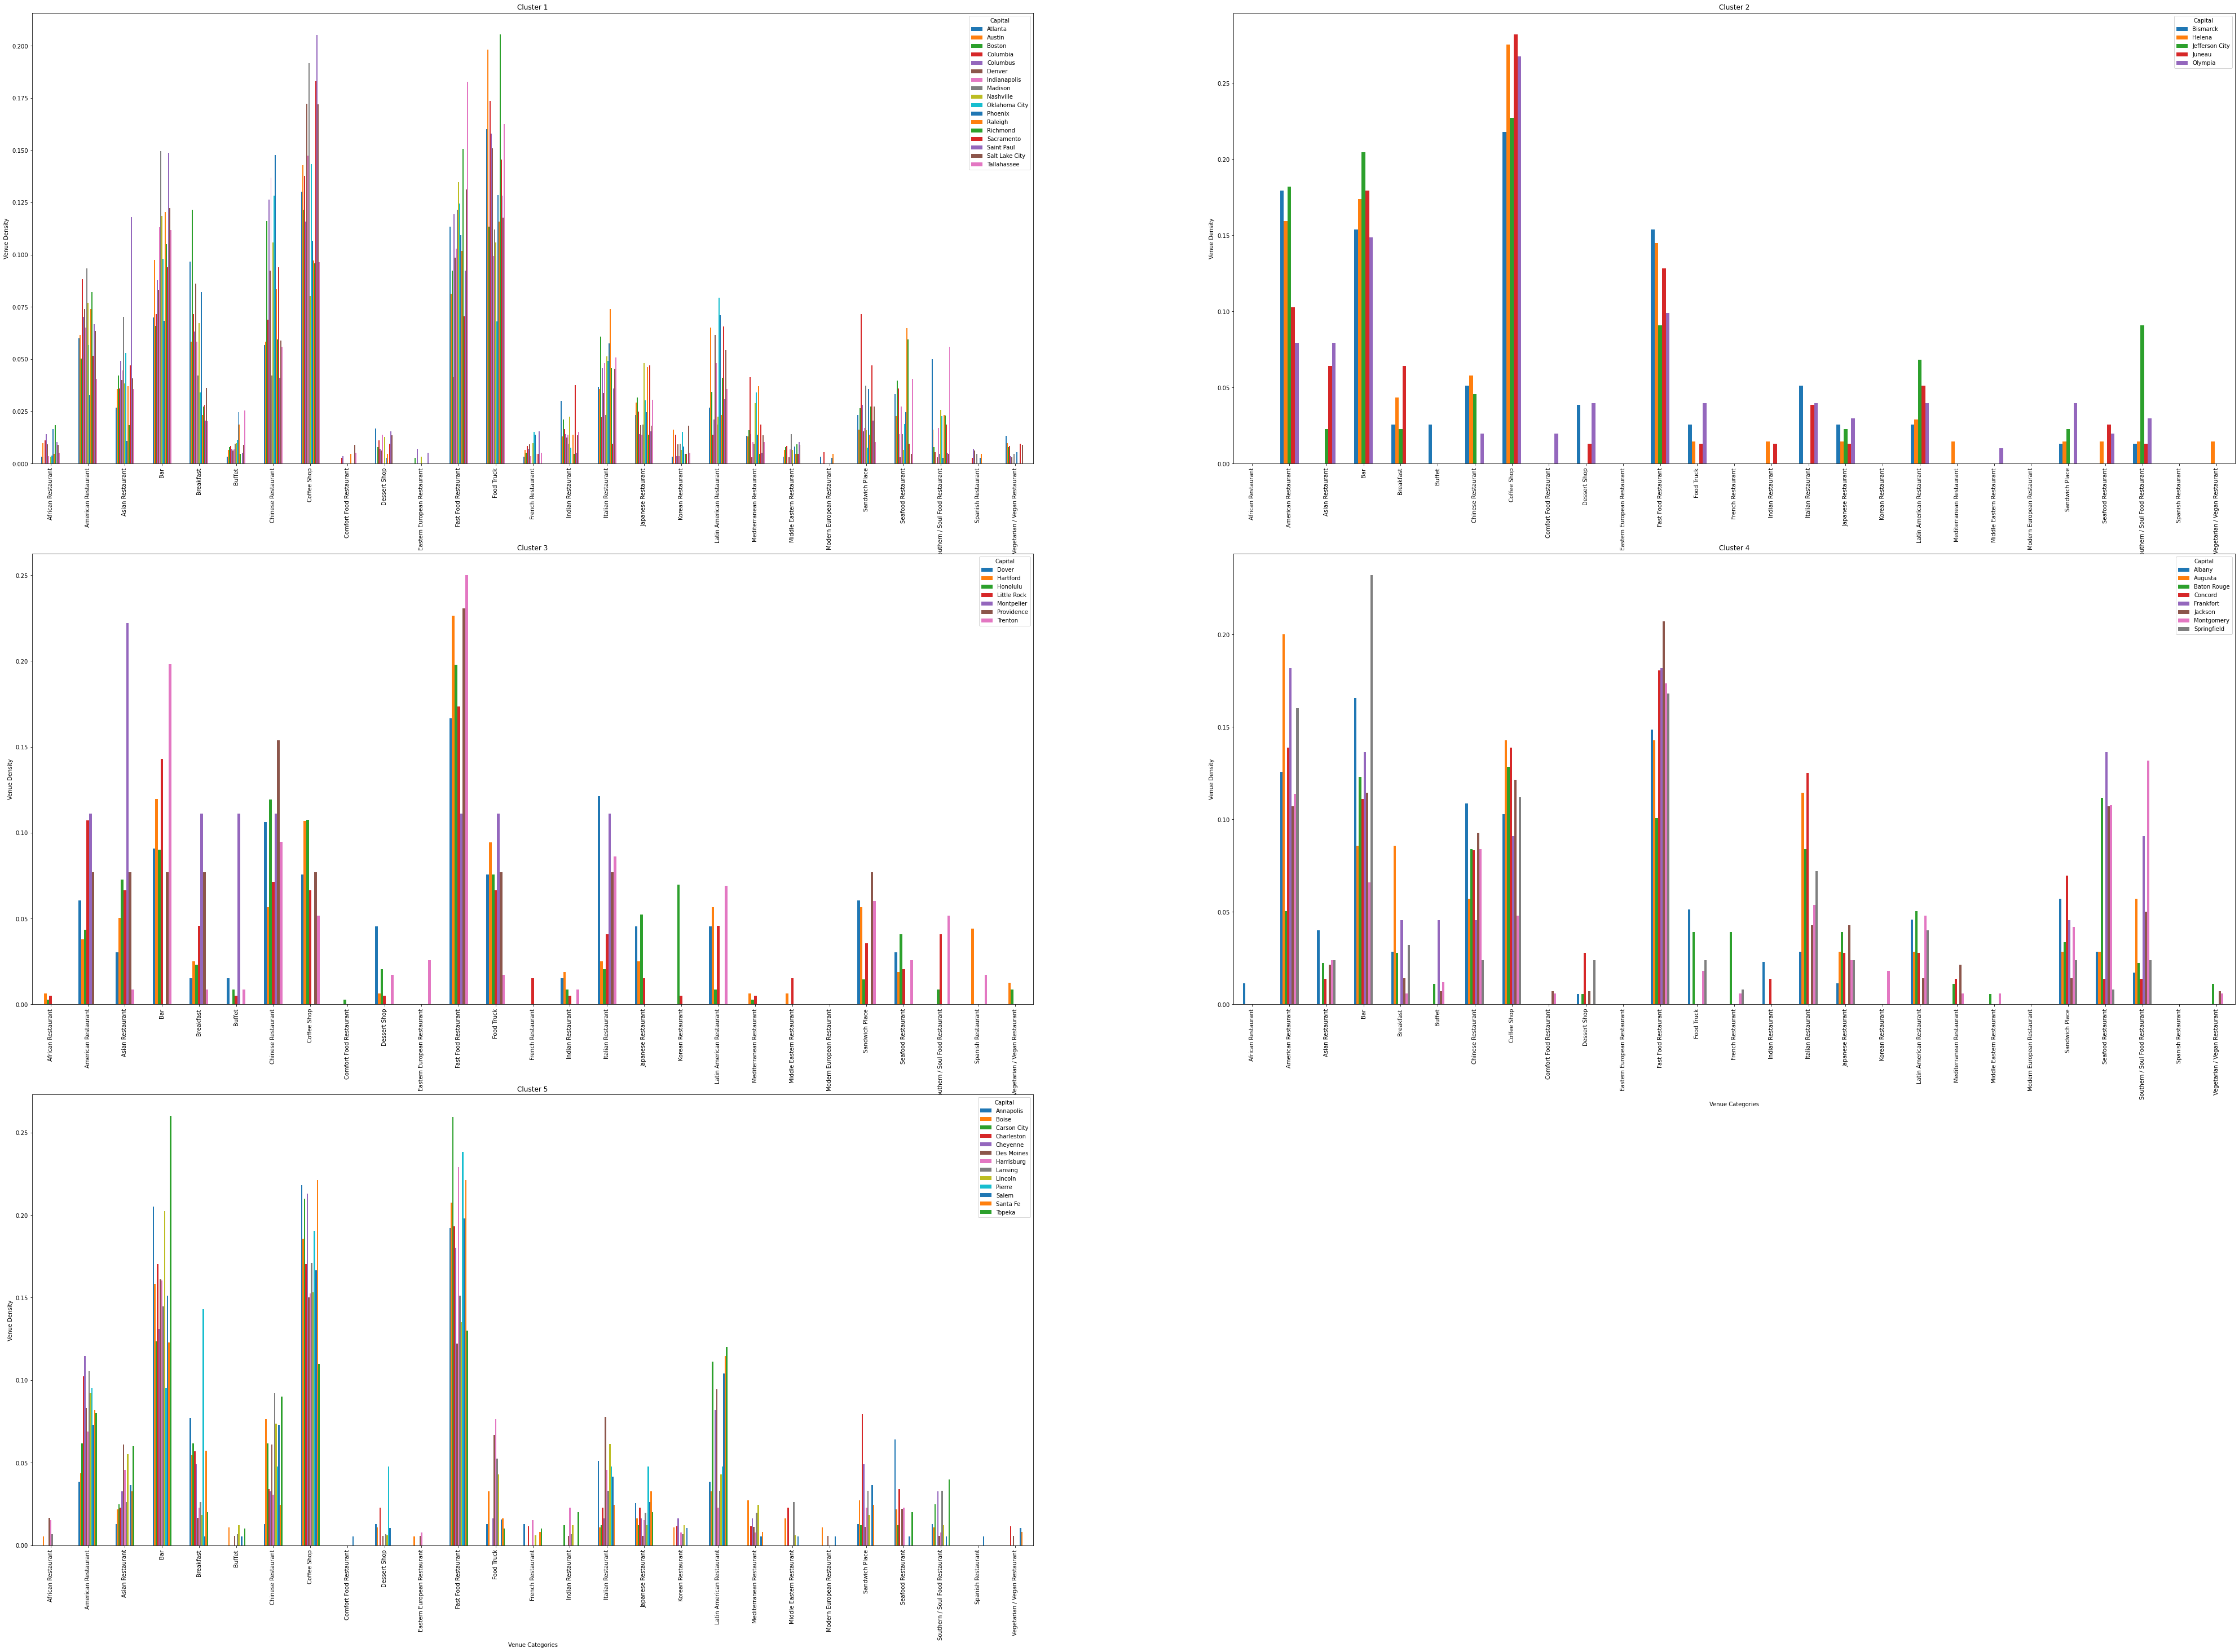

In [41]:
fig = plt.figure() # create figure

for i in range(1,6):
    ax = fig.add_subplot(3, 2, i)
    x = capital_grouped.copy()
    x.set_index('Capital', inplace=True)
    x.insert(0, 'Cluster Labels', kmeans.labels_)
    y = x.loc[x['Cluster Labels'] == i-1]
    y.drop('Cluster Labels',1,inplace=True)
    df_top5 = y.transpose()
    df_top5.index = df_top5.index.map(str) # let's change the index values of df_top5 to type integer for plotting
    df_top5.plot(kind='bar', 
                 figsize=(70, 50),
                 ax=ax
                 )
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Venue Categories')
    ax.set_ylabel('Venue Density')

plt.savefig('figure1.pdf')
plt.show()

Cluster 1 seems to be grouped based off high density of food trucks and bars

In [115]:
capital_merged.loc[capital_merged['Cluster Labels'] == 0, capital_merged.columns[[1] + list(range(5, capital_merged.shape[1]))]]

,Capital,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Phoenix,0,Chinese Restaurant,Food Truck,Fast Food Restaurant,Coffee Shop,Breakfast,Latin American Restaurant,Bar,Italian Restaurant,Sandwich Place,American Restaurant
4,Sacramento,0,Coffee Shop,Food Truck,Bar,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,American Restaurant,Sandwich Place,Asian Restaurant,Japanese Restaurant
5,Denver,0,Coffee Shop,Food Truck,Fast Food Restaurant,Chinese Restaurant,Breakfast,Bar,American Restaurant,Latin American Restaurant,Asian Restaurant,Italian Restaurant
8,Tallahassee,0,Fast Food Restaurant,Food Truck,Bar,Coffee Shop,Chinese Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Asian Restaurant
9,Atlanta,0,Food Truck,Coffee Shop,Fast Food Restaurant,Breakfast,Bar,American Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Seafood Restaurant
13,Indianapolis,0,Coffee Shop,Chinese Restaurant,Bar,Fast Food Restaurant,Food Truck,American Restaurant,Breakfast,Latin American Restaurant,Italian Restaurant,Asian Restaurant
20,Boston,0,Coffee Shop,Breakfast,Chinese Restaurant,Food Truck,Fast Food Restaurant,Bar,Italian Restaurant,American Restaurant,Asian Restaurant,Seafood Restaurant
22,Saint Paul,0,Coffee Shop,Bar,Food Truck,Asian Restaurant,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Italian Restaurant,Latin American Restaurant,Sandwich Place
32,Raleigh,0,Bar,Food Truck,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,American Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Asian Restaurant
34,Columbus,0,Food Truck,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Bar,American Restaurant,Breakfast,Asian Restaurant,Italian Restaurant,Sandwich Place


Cluster 2 seems to be high density of coffee shops and bars

In [116]:
capital_merged.loc[capital_merged['Cluster Labels'] == 1, capital_merged.columns[[1] + list(range(5, capital_merged.shape[1]))]]

,Capital,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Juneau,1,Coffee Shop,Bar,Fast Food Restaurant,American Restaurant,Asian Restaurant,Breakfast,Latin American Restaurant,Italian Restaurant,Seafood Restaurant,Dessert Shop
24,Jefferson City,1,Coffee Shop,Bar,American Restaurant,Southern / Soul Food Restaurant,Fast Food Restaurant,Latin American Restaurant,Chinese Restaurant,Sandwich Place,Asian Restaurant,Breakfast
25,Helena,1,Coffee Shop,Bar,American Restaurant,Fast Food Restaurant,Chinese Restaurant,Breakfast,Latin American Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Sandwich Place
33,Bismarck,1,Coffee Shop,American Restaurant,Fast Food Restaurant,Bar,Italian Restaurant,Chinese Restaurant,Dessert Shop,Latin American Restaurant,Food Truck,Breakfast
46,Olympia,1,Coffee Shop,Bar,Fast Food Restaurant,American Restaurant,Asian Restaurant,Food Truck,Dessert Shop,Sandwich Place,Latin American Restaurant,Italian Restaurant


Cluster 3 seems to be high density of fast food

In [117]:
capital_merged.loc[capital_merged['Cluster Labels'] == 2, capital_merged.columns[[1] + list(range(5, capital_merged.shape[1]))]]

,Capital,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Little Rock,2,Fast Food Restaurant,Bar,American Restaurant,Chinese Restaurant,Coffee Shop,Food Truck,Asian Restaurant,Breakfast,Latin American Restaurant,Italian Restaurant
6,Hartford,2,Fast Food Restaurant,Bar,Coffee Shop,Food Truck,Chinese Restaurant,Latin American Restaurant,Sandwich Place,Asian Restaurant,Spanish Restaurant,American Restaurant
7,Dover,2,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Bar,Coffee Shop,Food Truck,American Restaurant,Sandwich Place,Dessert Shop,Latin American Restaurant
10,Honolulu,2,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Bar,Food Truck,Asian Restaurant,Korean Restaurant,Japanese Restaurant,American Restaurant,Seafood Restaurant
29,Trenton,2,Fast Food Restaurant,Bar,Chinese Restaurant,Italian Restaurant,Latin American Restaurant,Sandwich Place,Southern / Soul Food Restaurant,Coffee Shop,Seafood Restaurant,Eastern European Restaurant
38,Providence,2,Fast Food Restaurant,Chinese Restaurant,American Restaurant,Asian Restaurant,Sandwich Place,Bar,Breakfast,Coffee Shop,Italian Restaurant,Food Truck
44,Montpelier,2,Asian Restaurant,Food Truck,American Restaurant,Breakfast,Buffet,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Bar


Cluster 4 seems to be 

In [118]:
capital_merged.loc[capital_merged['Cluster Labels'] == 3, capital_merged.columns[[1] + list(range(5, capital_merged.shape[1]))]]

,Capital,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Montgomery,3,Fast Food Restaurant,Southern / Soul Food Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,Bar,Italian Restaurant,Coffee Shop,Latin American Restaurant,Sandwich Place
12,Springfield,3,Bar,Fast Food Restaurant,American Restaurant,Coffee Shop,Italian Restaurant,Latin American Restaurant,Breakfast,Japanese Restaurant,Food Truck,Chinese Restaurant
16,Frankfort,3,Fast Food Restaurant,American Restaurant,Seafood Restaurant,Bar,Southern / Soul Food Restaurant,Coffee Shop,Sandwich Place,Breakfast,Buffet,Chinese Restaurant
17,Baton Rouge,3,Coffee Shop,Bar,Seafood Restaurant,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,American Restaurant,Latin American Restaurant,French Restaurant,Japanese Restaurant
18,Augusta,3,American Restaurant,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Bar,Breakfast,Chinese Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant,Seafood Restaurant
23,Jackson,3,Fast Food Restaurant,Coffee Shop,Bar,Seafood Restaurant,American Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Japanese Restaurant,Italian Restaurant,Asian Restaurant
28,Concord,3,Fast Food Restaurant,Coffee Shop,American Restaurant,Italian Restaurant,Bar,Chinese Restaurant,Sandwich Place,Japanese Restaurant,Dessert Shop,Latin American Restaurant
31,Albany,3,Bar,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Coffee Shop,Sandwich Place,Food Truck,Latin American Restaurant,Asian Restaurant,Breakfast


In [119]:
capital_merged.loc[capital_merged['Cluster Labels'] == 4, capital_merged.columns[[1] + list(range(5, capital_merged.shape[1]))]]

,Capital,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Boise,4,Fast Food Restaurant,Coffee Shop,Bar,Chinese Restaurant,Breakfast,American Restaurant,Latin American Restaurant,Food Truck,Sandwich Place,Mediterranean Restaurant
14,Des Moines,4,Bar,Coffee Shop,Fast Food Restaurant,Latin American Restaurant,American Restaurant,Italian Restaurant,Food Truck,Asian Restaurant,Chinese Restaurant,Seafood Restaurant
15,Topeka,4,Bar,Fast Food Restaurant,Latin American Restaurant,Coffee Shop,Chinese Restaurant,American Restaurant,Asian Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Breakfast
19,Annapolis,4,Coffee Shop,Bar,Fast Food Restaurant,Breakfast,Seafood Restaurant,Italian Restaurant,American Restaurant,Latin American Restaurant,Japanese Restaurant,Food Truck
21,Lansing,4,Coffee Shop,Fast Food Restaurant,Bar,American Restaurant,Chinese Restaurant,Food Truck,Southern / Soul Food Restaurant,Sandwich Place,Latin American Restaurant,Italian Restaurant
26,Lincoln,4,Bar,Coffee Shop,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Italian Restaurant,Asian Restaurant,Latin American Restaurant,Food Truck,Mediterranean Restaurant
27,Carson City,4,Fast Food Restaurant,Coffee Shop,Bar,Latin American Restaurant,American Restaurant,Breakfast,Chinese Restaurant,Asian Restaurant,Southern / Soul Food Restaurant,Sandwich Place
30,Santa Fe,4,Coffee Shop,Fast Food Restaurant,Bar,Latin American Restaurant,American Restaurant,Breakfast,Asian Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant
36,Salem,4,Fast Food Restaurant,Coffee Shop,Bar,Latin American Restaurant,American Restaurant,Chinese Restaurant,Italian Restaurant,Sandwich Place,Asian Restaurant,Japanese Restaurant
37,Harrisburg,4,Fast Food Restaurant,Bar,Coffee Shop,Food Truck,American Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,Seafood Restaurant,Sandwich Place


In [42]:
capital_table = capital_grouped.set_index(capital_grouped['Capital'])
capital_table = capital_table.drop('Capital', 1)


In [43]:
food_profiles = pd.read_csv('Food Profile.csv')
food_profiles.drop('Timestamp',axis=1, inplace=True)
food_profiles.set_index(food_profiles['Name'], inplace=True)
food_profiles.drop('Name', axis=1, inplace=True)

x = food_profiles.columns.to_list()
columns = {}
for i in x:
    j = i.split()
    j = j[2].replace('[', '').replace("'", '').replace(']', '')
    columns[i] = j

food_profiles.rename(columns=columns, inplace=True)
user_profiles = food_profiles.transpose()
users = user_profiles.columns.to_list()

for user in users:
    recommendation_table = (capital_table * user_profiles[user].values).sum(axis=1)  / (user_profiles[user].sum())
    recommendation_table = recommendation_table.sort_values(ascending=False)
    print(f'{user} will enjoy:')
    top_five = capital_merged.loc[capital_merged['Capital'].isin(recommendation_table.head().keys())]
    print(top_five[['Capital', 'State']])
    print('\n\n')

Lindsay  will enjoy:
        Capital         State
1        Juneau        Alaska
18      Augusta         Maine
27  Carson City        Nevada
30     Santa Fe    New Mexico
40       Pierre  South Dakota



Chris will enjoy:
     Capital           State
9    Atlanta         Georgia
18   Augusta           Maine
20    Boston   Massachusetts
39  Columbia  South Carolina
42    Austin           Texas



Eliza Henner Sparks will enjoy:
           Capital           State
4       Sacramento      California
24  Jefferson City        Missouri
39        Columbia  South Carolina
42          Austin           Texas
46         Olympia      Washington



Cole Bearrow will enjoy:
       Capital        State
0   Montgomery      Alabama
7        Dover     Delaware
16   Frankfort     Kentucky
23     Jackson  Mississippi
44  Montpelier      Vermont



Jared sparks will enjoy:
           Capital      State
15          Topeka     Kansas
17     Baton Rouge  Louisiana
24  Jefferson City   Missouri
35   Oklahoma C